In [6]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import curve_fit
from scipy.interpolate import interp1d

import sklearn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.models import load_model

os.getcwd()

'c:\\Users\\johnc\\Documents\\Python Scripts\\ocean-depth-characterization\\preliminary_models'

In [7]:
# import dataframe
df_norm_piv = pd.read_csv('../data/final_norm_set.csv')
cluster_indeces = ['HCB', 'PDCM', 'EQ', 'LCB', 'AR', 'SDCM']

# split data
full_train = df_norm_piv[df_norm_piv.train == 1]
full_test = df_norm_piv[df_norm_piv.train == 0]

# narrow down the features we want
X_train = full_train[['latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_aph_443_month']]
X_test = full_test[['latitude', 'longitude', 'date_doy_rad', 'sat_chl_month', 'sat_sst_month', 'sat_pic_month', 'sat_aph_443_month']]
# get labels
label_bins = [1, 2, 3, 4]
Y_train = full_train[['norm_' + str(i) for i in label_bins]]
Y_test = full_test[['norm_' + str(i) for i in label_bins]]

input_dim = X_train.shape[1]
output_dim = Y_train.shape[1]

#scale the data
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# set up the model
nn_model = Sequential()

nn_model.add(Dense(108, input_dim=input_dim, activation='relu'))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(28, activation='relu'))
nn_model.add(Dropout(0.3))
nn_model.add(Dense(output_dim))

nn_model.compile(loss='mse', optimizer='adam')

# fit the model
nn_history = nn_model.fit(X_train, Y_train, epochs=15, batch_size=32, verbose=1)

# check our MSE on the 4 prediction points
preds = nn_model.predict(X_test)
actuals = Y_test.to_numpy()
mean_squared_error(actuals, preds)

In [60]:
scaler.get_params()

{'copy': True, 'with_mean': True, 'with_std': True}

WOW NORMALIZED CLUSTERS WOOHOO


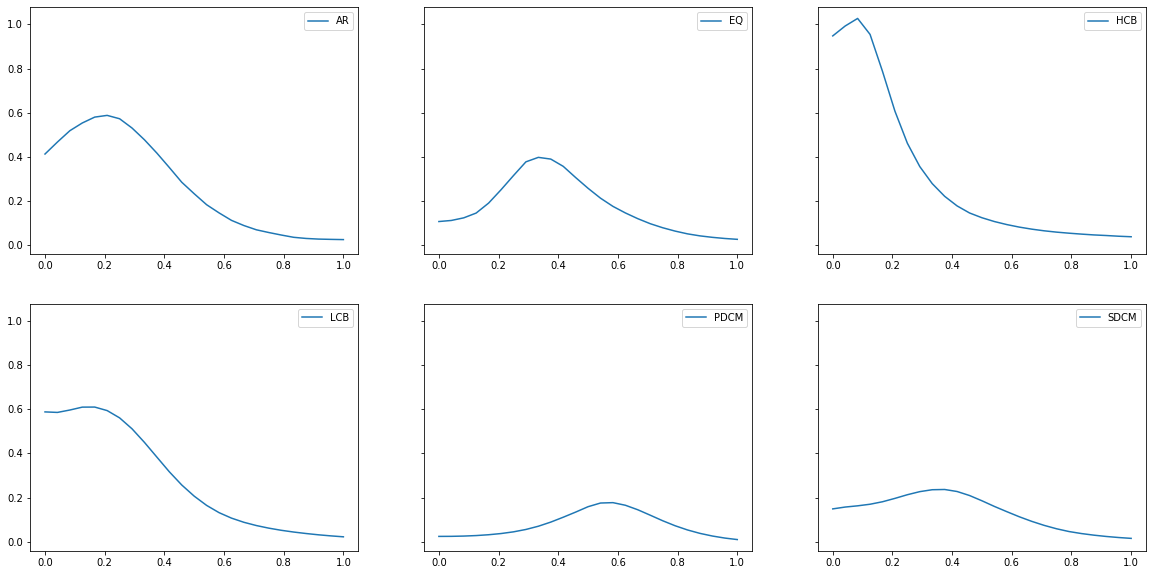

In [3]:
# create our normalized cluster distributions
df_known_dist = pd.read_csv('../data/cluster_chla_distribution.csv')

def build_normalized_cluster_centers(df_known_dist, n_points=25, plot_clusters=False, return_centers=True):
    out = pd.cut(df_known_dist.PRES, bins=25, labels=[i for i in range(25)])
    df_known_dist['depth_bin'] = out
    df_known_dist_binned = df_known_dist[['cluster', 'depth_bin', 'CHLA']] \
        .groupby(['cluster', 'depth_bin']).mean().reset_index().dropna()
    xnew = np.linspace(0, 1, n_points)
    raw_dists = list()
    norm_cluster_depths = {
        'AR': 14,
        'EQ': 18,
        'HCB': 23,
        'LCB': 23,
        'PDCM': 23,
        'SDCM': 20
    }
    if plot_clusters:
        fig, ax = plt.subplots(2, 3, figsize=(20, 10), sharey=True)
    for i, c in enumerate(np.unique(df_known_dist_binned.cluster)):
        ydata = df_known_dist_binned[df_known_dist_binned.cluster == c]['CHLA'].to_numpy()[:norm_cluster_depths[c]]
        xdata = np.linspace(0, 1, len(ydata))
        fc = interp1d(xdata, ydata, kind='slinear')
        ynew = fc(xnew)
        raw_dists.append(ynew)
        if plot_clusters:
            ax[i // 3, i % 3].plot(xnew, ynew, label=c)
            ax[i //3, i % 3].legend()
    if return_centers:
        return np.array(raw_dists)

print('WOW NORMALIZED CLUSTERS WOOHOO')
centers = build_normalized_cluster_centers(df_known_dist, plot_clusters=True)

In [4]:
# build kmeans for easy cluster prediction
kmeans = KMeans(n_clusters=6)
kmeans.fit(centers)

d:\langs\anaconda_dist\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


KMeans(n_clusters=6)

In [61]:
centers

array([[0.41317453, 0.46748513, 0.5188263 , 0.55383564, 0.58045696,
        0.58820526, 0.57298827, 0.53097843, 0.47768674, 0.41734389,
        0.35210721, 0.28540239, 0.23338234, 0.18364529, 0.14661946,
        0.11272519, 0.08926945, 0.070071  , 0.0576842 , 0.04639839,
        0.03605629, 0.03086947, 0.02797389, 0.02666722, 0.02564945],
       [0.10747704, 0.11232824, 0.12416936, 0.14590532, 0.19098353,
        0.25143391, 0.31557576, 0.3778138 , 0.39809846, 0.39030771,
        0.35749554, 0.30671173, 0.25797338, 0.21325299, 0.17613028,
        0.14640923, 0.12038377, 0.09768159, 0.07939508, 0.0641688 ,
        0.05165149, 0.04251336, 0.03589103, 0.03072038, 0.02685341],
       [0.94819012, 0.99308904, 1.02731265, 0.95491256, 0.78776714,
        0.60738444, 0.46215405, 0.35638285, 0.2792321 , 0.22171482,
        0.17823882, 0.14628394, 0.12463334, 0.10744187, 0.09367764,
        0.08226775, 0.07302317, 0.06549189, 0.05947828, 0.05468831,
        0.05050702, 0.0468269 , 0.04413142, 0.

In [22]:
# make prediction interpolations to match the xdata length in our kmeans algorithm
def interpolate_predictions(preds, n_points=25):
    '''
    interpolate our predictions so we can be on the same
    number line as our normalized clusters. this allows us to
    do kmeans predictions to help our predictions!
    '''
    interp_preds = list()
    xold = np.linspace(0, 1, 4)
    xnew = np.linspace(0, 1, n_points)
    for p in preds:
        fp = interp1d(xold, p, kind='quadratic')
        pnew = fp(xnew)
        interp_preds.append(pnew)
    return pd.DataFrame(np.array(interp_preds), columns=['intpred_' + str(i) for i in range(n_points)])

interpd_preds = interpolate_predictions(preds)

In [6]:
def mix_vals(x1, x2, perc_x1=0.5):
    perc_x2 = 1-perc_x1
    return (x1*perc_x1) + (x2*perc_x2)

In [23]:
# using our interpolated predictions and closest kmeans cluster
# we can make our final predictions
def build_final_predictions(interpd_preds, kmeans, mixture=0.2, n_points=25):
    kmeans_preds = kmeans.predict(interpd_preds)
    centers = kmeans.cluster_centers_
    final_predictions = list()
    for i, int_p in interpd_preds.iterrows():
        closest_center = centers[kmeans_preds[i], :]
        prediction = mix_vals(closest_center, int_p, perc_x1=mixture)
        final_predictions.append(prediction)
    return pd.DataFrame(np.array(final_predictions), columns=['fin_pred_' + str(i) for i in range(n_points)])

final_predictions = build_final_predictions(interpd_preds, kmeans, mixture=0.2).set_index(full_test.index)

d:\langs\anaconda_dist\envs\tf-gpu\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


In [9]:
# need to get all normalized values to compare to predictions
full_test

float  cycleNumber  latitude  longitude  date_doy_rad  sat_chl_month  \
0      1902303            1    49.236    -14.742      2.167505       0.435093   
13     1902303           14    48.071    -15.022      2.373934       0.489537   
22     1902303           23    47.512    -14.518      2.528756       0.455152   
35     1902303           38    46.467    -14.528      2.735185       0.379446   
39     1902303           42    46.495    -14.965      2.941614       0.407820   
...        ...          ...       ...        ...           ...            ...   
42319  7900589           36    55.980    -46.305      5.126322       0.344542   
42327  7901001            4    17.080    -24.424      1.169765       0.402191   
42331  7901001            8    16.898    -24.381      1.307384       0.450276   
42334  7901001           11    17.131    -24.170      1.410599       0.390988   
42335  7901001           12    16.968    -23.922      1.445004       0.208484   

       sat_sst_month  sat_par_month  sat_pic_month  sat_aph_443_month  ...  \
0          12.451869      39.556000       0.000184             0.0419  ...   
13         12.545573      43.624001       0.000062             0.0305  ...   
22         12.551631      42.734001       0.000016             0.0269  ...   
35         16.223672      47.417999       0.000236             0.0263  ...   
39         15.587559      46.472000       0.000016             0.0233  ...   
...              ...            ...            ...                ...  ...   
42319       7.610095      10.013996       0.000012             0.0342  ...   
42327      21.767555      49.087997       0.000010             0.0280  ...   
42331      21.822344      47.872002       0.000010             0.0309  ...   
42334      21.762587      49.129997       0.000010             0.0213  ...   
42335      21.850749      50.998001       0.000042             0.0128  ...   

       depth_bin_98  max_depth  train  cluster  max_bin    norm_1    norm_2  \
0          0.006024        232      0      HCB       24  0.704058  0.684214   
13         0.005314        150      0      HCB       16  0.897892  0.982076   
22         0.007528        140      0      HCB       15  1.105843  0.483426   
35         0.007174        136      0      HCB       14  0.709305  0.421599   
39         0.005134        104      0      HCB       11  0.722423  1.344044   
...             ...        ...    ...      ...      ...       ...       ...   
42319     -0.000005        124      0      HCB       13  0.489100  0.489100   
42327      0.000201        126      0       EQ       13  0.182500  0.182500   
42331      0.000020        149      0       EQ       15  0.306600  0.306916   
42334     -0.000818        145      0       EQ       15  0.186150  0.158747   
42335     -0.000135        132      0       EQ       14  0.065700  0.262275   

         norm_3    norm_4  cluster_val  
0      0.079771  0.017237            0  
13     0.047419  0.013270            0  
22     0.036941  0.012427            0  
35     0.043254  0.008991            0  
39     0.099630  0.012932            0  
...         ...       ...          ...  
42319  0.113302  0.009858            0  
42327  0.153279  0.003488            2  
42331  0.079549  0.004331            2  
42334  0.043956  0.002762            2  
42335  0.074056  0.003394            2  

[8243 rows x 119 columns]

In [17]:
# perform inference using the specified model path on 25 normalized points from zero to one
import numpy as np
import pandas as pd
import pickle
import keras
from keras.models import load_model
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from scipy.interpolate import interp1d

# set model path
MODEL_PATH = 'C:/Users/johnc/Documents/Python Scripts/ocean-depth-characterization/model_files/nn_multireg_108283'
SCALER_PATH = 'C:/Users/johnc/Documents/Python Scripts/ocean-depth-characterization/model_files/standardscaler_108283.pkl'


class ChlaPredictor():

    def __init__(self, model_path , scaler_path):
        
        # import necessary files
        print('Loading model...')
        self.model = load_model(model_path)
        self.scaler = pickle.load(open(scaler_path, 'rb'))
        print('Model loaded successfully')

        # set up kmeans for later
        self.centers = np.array([[0.41317453, 0.46748513, 0.5188263 , 0.55383564, 0.58045696,
                                    0.58820526, 0.57298827, 0.53097843, 0.47768674, 0.41734389,
                                    0.35210721, 0.28540239, 0.23338234, 0.18364529, 0.14661946,
                                    0.11272519, 0.08926945, 0.070071  , 0.0576842 , 0.04639839,
                                    0.03605629, 0.03086947, 0.02797389, 0.02666722, 0.02564945],
                                [0.10747704, 0.11232824, 0.12416936, 0.14590532, 0.19098353,
                                    0.25143391, 0.31557576, 0.3778138 , 0.39809846, 0.39030771,
                                    0.35749554, 0.30671173, 0.25797338, 0.21325299, 0.17613028,
                                    0.14640923, 0.12038377, 0.09768159, 0.07939508, 0.0641688 ,
                                    0.05165149, 0.04251336, 0.03589103, 0.03072038, 0.02685341],
                                [0.94819012, 0.99308904, 1.02731265, 0.95491256, 0.78776714,
                                    0.60738444, 0.46215405, 0.35638285, 0.2792321 , 0.22171482,
                                    0.17823882, 0.14628394, 0.12463334, 0.10744187, 0.09367764,
                                    0.08226775, 0.07302317, 0.06549189, 0.05947828, 0.05468831,
                                    0.05050702, 0.0468269 , 0.04413142, 0.04092826, 0.03857374],
                                [0.58818818, 0.58583076, 0.59669966, 0.60978989, 0.61007765,
                                    0.59415282, 0.56115817, 0.5115877 , 0.45002541, 0.38337771,
                                    0.31698094, 0.25713183, 0.20664978, 0.16475079, 0.13189105,
                                    0.10709871, 0.08817151, 0.07348845, 0.06169837, 0.05202374,
                                    0.04407668, 0.03737277, 0.03151687, 0.02664956, 0.02245804],
                                [0.02434728, 0.02460363, 0.02581248, 0.02812329, 0.03187796,
                                    0.03727261, 0.04495509, 0.05575595, 0.07037495, 0.08910255,
                                    0.11114404, 0.13437359, 0.15886012, 0.17547859, 0.17721822,
                                    0.16539735, 0.14497307, 0.12034047, 0.09528552, 0.07258161,
                                    0.05346715, 0.03802479, 0.02601964, 0.01678069, 0.00998742],
                                [0.14894491, 0.15727387, 0.16281632, 0.17001331, 0.18123477,
                                    0.19650756, 0.21308114, 0.22705645, 0.23570769, 0.23681044,
                                    0.22765918, 0.2095035 , 0.18564293, 0.16008297, 0.13634142,
                                    0.11333204, 0.09254978, 0.07431426, 0.05888546, 0.04637136,
                                    0.03724998, 0.02995289, 0.02402373, 0.0192311 , 0.01539957]])
        self.kmeans = KMeans(n_clusters=6)
        self.kmeans.fit(self.centers)

    def make_inference(self, input_features):
        '''
        model prediction

        interpolation of results

        kmeans prediction and mixing
        '''
        # make input have dimensions for model
        try:
            in_dim = input_features.shape[1]
        except IndexError:
            input_features = np.array([input_features])
        scaled_features = self.scaler.transform(input_features)
        # make raw predictions
        preds = self.model.predict(scaled_features)
        int_preds = self.interpolate(preds)
        final_predictions = self.create_mixture(int_preds)
        return final_predictions
    
    def interpolate(self, predictions):
        
        n_points = 25
        # interpolate results
        xold = np.linspace(0, 1, 4)
        xnew = np.linspace(0, 1, n_points)
        int_predictions = list()
        for prediction in predictions:
            fp = interp1d(xold, prediction, kind='quadratic')
            int_predictions.append(fp(xnew))
        int_preds_df = pd.DataFrame(np.array(int_predictions), columns=['intpred_' + str(i) for i in range(n_points)])
        return int_preds_df
    
    def create_mixture(self, int_preds, mixture=0.2):
        n_points = 25

        kmeans_preds = self.kmeans.predict(int_preds)
        centers = self.kmeans.cluster_centers_
        final_predictions = list()
        for i, int_p in int_preds.iterrows():
            closest_center = centers[kmeans_preds[i], :]
            prediction = self.mix_vals(closest_center, int_p, perc_x1=mixture)
            final_predictions.append(prediction)
        fin_preds = np.array(final_predictions)
    
    def mix_vals(self, x1, x2, perc_x1=0.5):
        perc_x2 = 1-perc_x1
        return (x1*perc_x1) + (x2*perc_x2)

In [18]:
test_model = ChlaPredictor(MODEL_PATH, SCALER_PATH)

Loading model...
Model loaded successfully


d:\langs\anaconda_dist\envs\tf-gpu\lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [19]:
inputs_test = X_train[:5, :]
test_model.make_inference(inputs_test)

1/1 [==============================] - 0s 41ms/step


d:\langs\anaconda_dist\envs\tf-gpu\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but KMeans was fitted without feature names
  warnings.warn(


array([[ 1.25007535, -0.05221946, -0.4539949 ,  1.20127058, -0.50250003,
         0.23860393,  0.75879659],
       [ 1.24555375, -0.05209212, -0.44501175,  0.44802887, -0.50697751,
         0.06496921,  0.60040115],
       [ 1.24257247, -0.05305293, -0.4360286 ,  0.26223868, -0.51227235,
        -0.11654464,  0.58355245],
       [ 1.24070918, -0.05427999, -0.42704545,  0.33988251, -0.53042969,
         0.19124098,  0.21622349],
       [ 1.23869682, -0.0554839 , -0.4180623 ,  0.15835355, -0.50723624,
        -0.06130257,  0.34091351]])